<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/09_CGAN_DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CGAN and DCGAN

Conditional Generative Adversarial Nets，简单来说就是条件生成-对抗网络。在生成器以及判别器上它都多了一个标签作为输入。

所以，生成器的输入是噪声和标签，输出还是生成图；判别器的输入是生成图，真实图以及标签，输出还是真和假。

之前的GAN教程，实验数据用的是简单的散点，在本教程中，我们使用MNIST，结果更加形象。

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# 基本参数
z_dim = 100
batch_size = 128
learning_rate = 0.0002
total_epochs = 30

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载MNIST数据集
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size, shuffle=False, drop_last=True)

## CGAN

首先实现CGAN。下面分别是 **判别器** 和 **生成器** 的网络结构，可以看出网络结构非常简单，具体如下：
- 生成器：(784 + 10) ==> 512 ==> 256 ==> 1
- 判别器：(100 + 10) ==> 128 ==> 256 ==> 512 ==> 784

可以看出，去掉生成器和判别器那 10 维的标签信息，和普通的GAN是完全一样的。下面是网络的具体实现代码：

In [0]:
class Discriminator(nn.Module):
	'''全连接判别器，用于1x28x28的MNIST数据,输出是数据和类别'''
	def __init__(self):
		super(Discriminator, self).__init__()
		self.model = nn.Sequential(
			  nn.Linear(28*28+10, 512),
			  nn.LeakyReLU(0.2, inplace=True),
			  nn.Linear(512, 256),
			  nn.LeakyReLU(0.2, inplace=True),
			  nn.Linear(256, 1),
			  nn.Sigmoid()
		)
  
	def forward(self, x, c):
		x = x.view(x.size(0), -1)
		validity = self.model(torch.cat([x, c], -1))
		return validity

class Generator(nn.Module):
	'''全连接生成器，用于1x28x28的MNIST数据，输入是噪声和类别'''
	def __init__(self, z_dim):
		super(Generator, self).__init__()
		self.model = nn.Sequential(
			  nn.Linear(z_dim+10, 128),
			  nn.LeakyReLU(0.2, inplace=True),
			  nn.Linear(128, 256),
			  nn.BatchNorm1d(256, 0.8),
			  nn.LeakyReLU(0.2, inplace=True),
			  nn.Linear(256, 512),
			  nn.BatchNorm1d(512, 0.8),
			  nn.LeakyReLU(0.2, inplace=True),
			  nn.Linear(in_features=512, out_features=28*28),
			  nn.Tanh()
	 	)

	def forward(self, z, c):
		x = self.model(torch.cat([z, c], dim=1))
		x = x.view(-1, 1, 28, 28)
		return x

下面定义相关的模型：

In [0]:
# 初始化构建判别器和生成器
discriminator = Discriminator().to(device)
generator = Generator(z_dim=z_dim).to(device)

# 初始化二值交叉熵损失
bce = torch.nn.BCELoss().to(device)
ones = torch.ones(batch_size).to(device)
zeros = torch.zeros(batch_size).to(device)

# 初始化优化器，使用Adam优化器
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

开始训练：

In [0]:
# 开始训练，一共训练total_epochs
for epoch in range(total_epochs):

	# torch.nn.Module.train() 指的是模型启用 BatchNormalization 和 Dropout
	# torch.nn.Module.eval() 指的是模型不启用 BatchNormalization 和 Dropout
	# 因此，train()一般在训练时用到， eval() 一般在测试时用到
	generator = generator.train()

	# 训练一个epoch
	for i, data in enumerate(dataloader):

		# 加载真实数据
		real_images, real_labels = data
		real_images = real_images.to(device)
		# 把对应的标签转化成 one-hot 类型
		tmp = torch.FloatTensor(real_labels.size(0), 10).zero_()
		real_labels = tmp.scatter_(dim=1, index=torch.LongTensor(real_labels.view(-1, 1)), value=1)
		real_labels = real_labels.to(device)

		# 生成数据
		# 用正态分布中采样batch_size个随机噪声
		z = torch.randn([batch_size, z_dim]).to(device)
		# 生成 batch_size 个 ont-hot 标签
		c = torch.FloatTensor(batch_size, 10).zero_()
		c = c.scatter_(dim=1, index=torch.LongTensor(np.random.choice(10, batch_size).reshape([batch_size, 1])), value=1)
		c = c.to(device)
		# 生成数据
		fake_images = generator(z,c)

		# 计算判别器损失，并优化判别器
		real_loss = bce(discriminator(real_images, real_labels), ones)
		fake_loss = bce(discriminator(fake_images.detach(), c), zeros)
		d_loss = real_loss + fake_loss

		d_optimizer.zero_grad()
		d_loss.backward()
		d_optimizer.step()

		# 计算生成器损失，并优化生成器
		g_loss = bce(discriminator(fake_images, c), ones)

		g_optimizer.zero_grad()
		g_loss.backward()
		g_optimizer.step()

	# 输出损失
	print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, total_epochs, d_loss.item(), g_loss.item()))


下面我们用随机噪声生成一组图像，看看CGAN的效果：

In [0]:
#用于生成效果图
# 生成100个随机噪声向量
fixed_z = torch.randn([100, z_dim]).to(device)
# 生成100个one_hot向量，每类10个
fixed_c = torch.FloatTensor(100, 10).zero_()
fixed_c = fixed_c.scatter_(dim=1, index=torch.LongTensor(np.array(np.arange(0, 10).tolist()*10).reshape([100, 1])), value=1)
fixed_c = fixed_c.to(device)

generator = generator.eval()
fixed_fake_images = generator(fixed_z, fixed_c)

plt.figure(figsize=(8, 8))
for j in range(10):
    for i in range(10):
        img = fixed_fake_images[j*10+i, 0, :, :].detach().cpu().numpy()
        img = img.reshape([28, 28])
        plt.subplot(10, 10, j*10+i+1)
        plt.imshow(img, 'gray')

我曾经把epoch设置成200，CGAN生成的效果还是非常不错的 ~~~ 如下所示：

![CGAN](http://q6dz4bbgt.bkt.clouddn.com/FsAc9HE6vdT_TOnZzOeXd6Kq0U1b)

但后来很长时间都跑不出来这个结果了，不清楚是哪里的设置出问题了，很忧伤 ~~~ 

考虑到上面代码是把图像直接拉成一个向量来处理，没有考虑空间上的特性，因此，效果理论上会不如使用卷积操作的 DCGAN。两者代码也非常类似，我们下面比较一下。

## DCGAN

下面我们实现DCGAN。下面分别是 **判别器** 和 **生成器** 的网络结构，和之前类似，只是使用了卷积结构。

In [0]:
class D_dcgan(nn.Module):
	'''滑动卷积判别器'''
	def __init__(self):
		super(D_dcgan, self).__init__()
		self.conv = nn.Sequential(
            # 第一个滑动卷积层，不使用BN，LRelu激活函数
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 第二个滑动卷积层，包含BN，LRelu激活函数
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # 第三个滑动卷积层，包含BN，LRelu激活函数
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 第四个滑动卷积层，包含BN，LRelu激活函数
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

		# 全连接层+Sigmoid激活函数
		self.linear = nn.Sequential(nn.Linear(in_features=128, out_features=1), nn.Sigmoid())

	def forward(self, x):
		x = self.conv(x)
		x = x.view(x.size(0), -1)
		validity = self.linear(x)
		return validity

class G_dcgan(nn.Module):
	'''反滑动卷积生成器'''

	def __init__(self, z_dim):
		super(G_dcgan, self).__init__()
		self.z_dim = z_dim
		# 第一层：把输入线性变换成256x4x4的矩阵，并在这个基础上做反卷机操作
		self.linear = nn.Linear(self.z_dim, 4*4*256)
		self.model = nn.Sequential(
            # 第二层：bn+relu
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 第三层：bn+relu
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 第四层:不使用BN，使用tanh激活函数
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=2),
            nn.Tanh()
        )

	def forward(self, z):
		# 把随机噪声经过线性变换，resize成256x4x4的大小
		x = self.linear(z)
		x = x.view([x.size(0), 256, 4, 4])
		# 生成图片
		x = self.model(x)
		return x

定义相关的模型：

In [0]:
# 构建判别器和生成器
d_dcgan = D_dcgan().to(device)
g_dcgan = G_dcgan(z_dim=z_dim).to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# 使用均值为0，方差为0.02的正态分布初始化神经网络
d_dcgan.apply(weights_init_normal)
g_dcgan.apply(weights_init_normal)

# 初始化优化器，使用Adam优化器
g_dcgan_optim = optim.Adam(g_dcgan.parameters(), lr=learning_rate)
d_dcgan_optim = optim.Adam(d_dcgan.parameters(), lr=learning_rate)

# 加载MNIST数据集，和之前不同的是，DCGAN输入的图像被 resize 成 32*32 像素
dcgan_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
        ), batch_size, shuffle=True, drop_last=True)

开始训练模型：

In [41]:
# 开始训练，一共训练 total_epochs

for e in range(total_epochs):

	# 给generator启用 BatchNormalization
	g_dcgan = g_dcgan.train()
	# 训练一个epoch
	for i, data in enumerate(dcgan_dataloader):

		# 加载真实数据，不加载标签
		real_images, _ = data
		real_images = real_images.to(device)

		# 用正态分布中采样batch_size个噪声，然后生成对应的图片
		z = torch.randn([batch_size, z_dim]).to(device)
		fake_images = g_dcgan(z)

		# 计算判别器损失，并优化判别器
		real_loss = bce(d_dcgan(real_images), ones)
		fake_loss = bce(d_dcgan(fake_images.detach()), zeros)
		d_loss = real_loss + fake_loss

		d_dcgan_optim.zero_grad()
		d_loss.backward()
		d_dcgan_optim.step()

		# 计算生成器损失，并优化生成器
		g_loss = bce(d_dcgan(fake_images), ones)

		g_dcgan_optim.zero_grad()
		g_loss.backward()
		g_dcgan_optim.step()
		
    # 输出损失
	print ("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (e, total_epochs, d_loss.item(), g_loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[Epoch 0/30] [D loss: 1.045440] [G loss: 0.970043]
[Epoch 1/30] [D loss: 0.982702] [G loss: 1.100872]
[Epoch 2/30] [D loss: 0.977530] [G loss: 1.125384]
[Epoch 3/30] [D loss: 0.848266] [G loss: 1.203098]
[Epoch 4/30] [D loss: 0.867079] [G loss: 1.215819]
[Epoch 5/30] [D loss: 0.731456] [G loss: 1.605735]
[Epoch 6/30] [D loss: 0.370109] [G loss: 2.159085]
[Epoch 7/30] [D loss: 0.177716] [G loss: 2.797460]
[Epoch 8/30] [D loss: 0.122290] [G loss: 3.515564]
[Epoch 9/30] [D loss: 0.067713] [G loss: 4.166862]
[Epoch 10/30] [D loss: 0.049966] [G loss: 4.166396]
[Epoch 11/30] [D loss: 0.071364] [G loss: 4.487647]
[Epoch 12/30] [D loss: 0.032918] [G loss: 4.669094]
[Epoch 13/30] [D loss: 0.067831] [G loss: 4.622688]
[Epoch 14/30] [D loss: 0.016590] [G loss: 5.150414]
[Epoch 15/30] [D loss: 0.039516] [G loss: 4.939036]
[Epoch 16/30] [D loss: 0.013571] [G loss: 6.400079]
[Epoch 17/30] [D loss: 0.064513] [G loss: 4.190432]
[Epoch 18/30] [D loss: 0.036726] [G loss: 4.953189]
[Epoch 19/30] [D loss:

下面我们用一组随机噪声输出图像，看看DCGAN的效果：

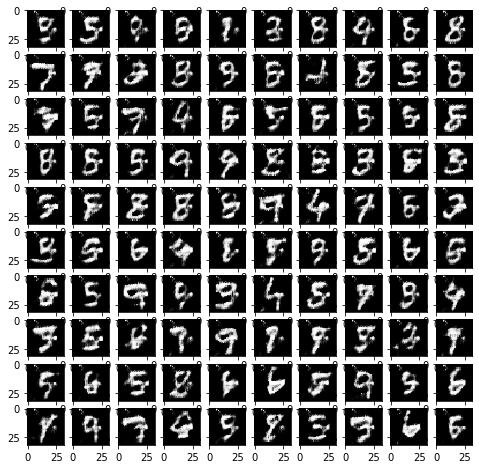

In [42]:
#用于生成效果图
# 生成100个随机噪声向量
fixed_z = torch.randn([100, z_dim]).to(device)
g_dcgan = g_dcgan.eval()
fixed_fake_images = g_dcgan(fixed_z)

plt.figure(figsize=(8, 8))
for j in range(10):
    for i in range(10):
        img = fixed_fake_images[j*10+i, 0, :, :].detach().cpu().numpy()
        img = img.reshape([32, 32])
        plt.subplot(10, 10, j*10+i+1)
        plt.imshow(img, 'gray')

这里只用了30个 epoch，效果还可以，如果增大 epoch 的数量，效果可能会更好，大家可以自己试一试。